# The HFM library - A fast marching solver with adaptive stencils

## Part : Other applications
## Chapter : The medial axis, and an application to curve denoising

**The medial axis.** Given a subset $\Gamma$ of a domain $\Omega$, the medial axis is defined as the collection of points $x\in \Omega$ where the distance
$$
    d_\Gamma(x) := \min_{y \in \Gamma} d(x,y)
$$
is not differentiable. The concept makes senses for subsets of $R^d$ equipped with the Euclidean distance, but also in more general metric spaces, such as Riemannian manifolds. In the latter case, the medial axis is often referred to as the *cut-locus*.

Computing the medial axis is a common problem in computer geometry, for which there exists a variety of methods. 
In this notebook, we use a naive approach based on numerically approximating the distance map, estimating its hessian, and pruning. This method is certainly not the most accurate, but it is quite robust to noise, which is often an issue in this context, and works in two and three dimensions. The eigenvalues and eigenvectors of this hessian matrix also provides valuable information on the structure of the medial axis. 

**Curve denoising.** 
I present an application of the medial axis computation to curve denoising, with the property that *smooth curves are left (exactly) invariant*. The algorithm consists of three steps:
* Compute a tubular neighborhood of the curve, with radius $r>0$.
* Compute the medial axis of this tubular neighborhood.
* Replace the original curve with a shortest curve through this medial axis, with the same endpoints.

The fast marching algorithm is used three times in this process, once for each step. The surprising mathematical property of this method is the following, stated informally: 
* *Assume that the radius of curvature (and local feature size) of the original curve is bounded by $r$. Then the original curve and the smoothed curve coincide exactly.

This property is in sharp contrast with other curve evolution methods such as the curve shortening flow, which only leaves invariant straight lines. A common practical solution is to introduce a data fidelity term in the optimized functional, so as to prevent excessive drift, in particular towards the interior of the curved regions. Nevertheless, a bias is introduced, even if the original curve is smooth.

This numerical experiment on curve denoising is freely inspired by the following preprint: Santana-Cedrés, D., Monzón, N., & Alvarez, L. (2015). *An Algorithm for 3D Curve Smoothing.* [link](http://www.ipol.im/pub/pre/292/preprint.pdf)



[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Computation of the medial axis](#1.-Computation-of-the-medial-axis)
    * [1.1 Euclidean distance to an object](#1.1-Euclidean-distance-to-an-object)
    * [1.2 Gaussian hessian filtering](#1.2-Gaussian-hessian-filtering)
    * [1.3 Eigen-analysis and the medial axis](#1.3-Eigen-analysis-and-the-medial-axis)
  * [2. Planar curve extraction and smoothing](#2.-Planar-curve-extraction-and-smoothing)
    * [2.1 Tubular neighborhood of a curve](#2.1-Tubular-neighborhood-of-a-curve)
    * [2.2 Curve smoothing](#2.2-Curve-smoothing)
    * [2.3 Analysis of the results](#2.3-Analysis-of-the-results)
    * [2.4 Further smoothing ?](#2.4-Further-smoothing-?)
  * [3. Three dimensional curves](#3.-Three-dimensional-curves)
    * [3.1 Curve smoothing](#3.1-Curve-smoothing)
    * [3.2 Analysis of the results](#3.2-Analysis-of-the-results)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('MedialAxis','FMM'))

In [2]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import Metrics
from agd import Plotting

In [3]:
import numpy as np; xp=np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter,maximum_filter,minimum_filter
import time

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver. (Comment it for the CPU eikonal solver.)

In [4]:
#Eikonal.dictIn.default_mode = 'gpu_transfer'

Alternatively, with a recent cupy version, you should be able to use the cupyx.scipy.ndimage module.

## 1. Computation of the medial axis

We compute the medial axis of a cartoon image, by numerically computing and then differentiating the distance map.

In [5]:
image0 = Plotting.imread("Notebooks_FMM/TestImages/netclipart.com-pigs-clipart-black-and-2011693.png")

In [6]:
image = image0[:,:,3]>0.5

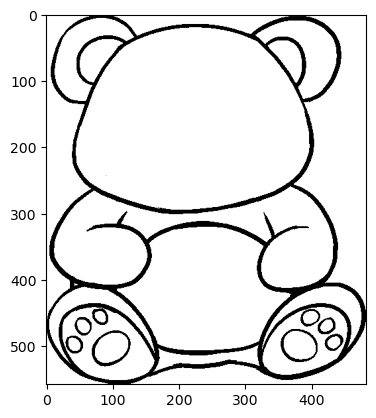

In [7]:
plt.imshow(image,cmap="Greys");

### 1.1 Euclidean distance to an object

As could be expected in this series of notebooks, we rely on the fast marching method to compute the Euclidean distance to the object boundary.

In [8]:
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'exportValues':1,
    'cost':1,
    'gridScale':1,
    'dims':image.shape,
    'order':2
})
X = hfmIn.Grid()
hfmIn['seeds'] = X[:,image].T

In [9]:
hfmOut=hfmIn.Run()

Field verbosity defaults to 1
Field origin defaults to {0,0}
Field seedRadius defaults to 0
Fast marching solver completed in 0.056444 s.


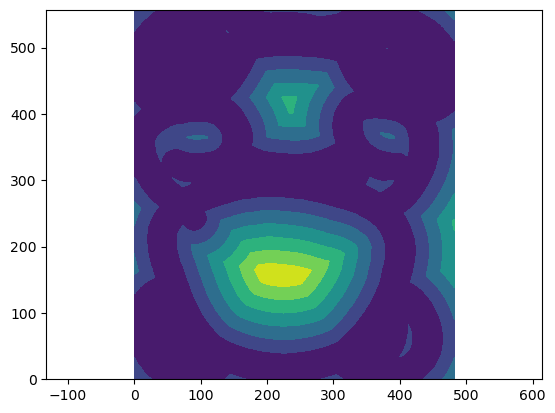

In [10]:
plt.contourf(hfmOut['values'])
plt.axis('equal');

### 1.2 Gaussian hessian filtering

The medial axis of an object $\Gamma$ is defined as the set of points where the distance $d_\Gamma$ to that object is not differentiable. Nevertheless, this will not stop us from differentiating $d_\Gamma$, *twice*.

*In the continuous setting*, the hessian $H$ of $d_\Gamma$ can be regarded as a signed measure, with values in the symmetric matrices. If the curve $\Gamma$ is sufficiently smooth (and perhaps other technical assumptions), one can decompose $H = H_d {\mathcal L}_\Omega + H_{d-1} {\mathcal L}_M $, where $M$ denotes the medial axis of $\Gamma$, which is a piecewise smooth $d-1$ dimensional manifold, and $L_M$ denotes the $d-1$ dimensional Lebesgue measure on it.
The eigenvalues and eigenvectors of $H_{d-1}$ at a point $x\in M$ can be described in terms of the tangent space to the medial axis $M$ at $x$, and the angle between the points of $\Gamma$ closest to $x$. In addition, $H_{d-1}$ is *everywhere negative semi-definite*.

*In the discrete setting*, we differentiate a mollification of $d_\Gamma$, defined through a Gaussian kernel.

In [11]:
def hessian(image,sigma):
    """
    Estimate of gaussian of an image.
    Inputs :
     - image: to be filtered
     - sigma : standard deviation, measured in pixels
    """
    rg=range(image.ndim)
    return np.array([[gaussian_filter(image,sigma,order=[(i,j).count(k) for k in rg]) 
                      for i in rg] for j in rg])

In [12]:
hess = hessian(hfmOut['values'],2.)

In [13]:
frob = (hess**2).sum(axis=(0,1))

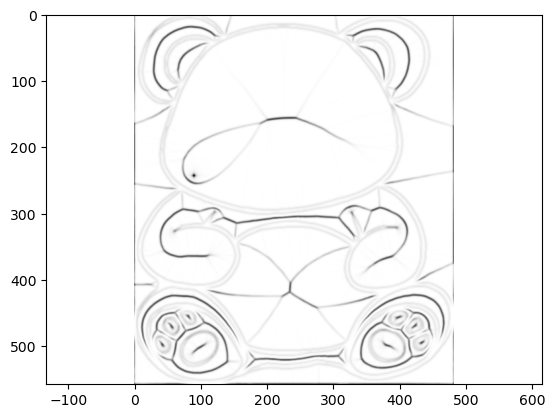

In [14]:
plt.imshow(frob,cmap='Greys')
plt.axis('equal');

### 1.3 Eigen-analysis and the medial axis

As discussed above, strongly negative eigenvalues of $d_\Gamma$ correspond to the medial axis, and the corresponding eigenvector is orthogonal to the medial axis. There also exists faint lines of positive eigenvalues, which illustrate the instability of the medial axis computation.

Strongly positive eigenvalues only occur on the boundary $\Gamma$ from which the distance is computed.

In [15]:
def eigh(m):
    """Eigenvalues and eigenvectors, of m, with geometric dimensions first."""
    eVals,eVec = np.linalg.eigh(np.moveaxis(m,(0,1),(-2,-1)))
    return np.moveaxis(eVals,-1,0),np.moveaxis(eVec,(-2,-1),(1,0))

In [16]:
eVals,eVec = eigh(hess) # eVals are sorted

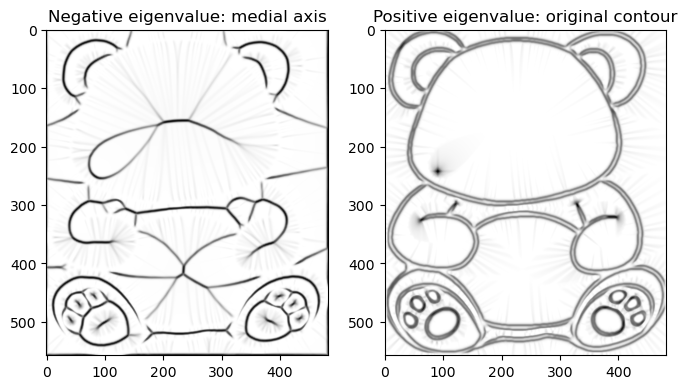

In [17]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
plt.title("Negative eigenvalue: medial axis")
plt.imshow(np.maximum(-eVals[0],0),cmap='Greys');

plt.subplot(1,2,2)
plt.title("Positive eigenvalue: original contour")
plt.imshow(np.maximum(eVals[1],0),cmap='Greys');

## 2. Planar curve extraction and smoothing

As discribed in the introduction, we consider a curve smoothing method, based on replacing the curve with the medial axis of its tubular neighborhood.

### 2.1 Tubular neighborhood of a curve

As could be expected, we rely on the fast marching method to compute the Euclidean distance to a curve, and define a tubular neighborhood.

In [18]:
def spiral2(t):
    u = np.sqrt(t) # Reparametrization for approx constant speed
    return np.array((np.cos(u),np.sin(u)))*u
def oscillations2(t):
    t=1.5*t
    return np.array((np.cos(.6*t)+np.sin(.4*t),np.cos(.5*t)+np.sin(.7*t)))

In [19]:
np.random.seed(42) # reproducibility

In [20]:
spiral2_t = np.linspace(np.pi,5*np.pi,300)**2
spiral2_exact = spiral2(spiral2_t)
spiral2_noisy = spiral2_exact + 0.5*np.random.normal(size=spiral2_exact.shape)
spiral2_osc = spiral2_exact + 0.5*oscillations2(spiral2_t)
spiral2_noisy_osc = spiral2_exact+ 0.4*(oscillations2(spiral2_t)+np.random.normal(size=spiral2_exact.shape))

spirals2 = {'exact':spiral2_exact,'noisy':spiral2_noisy,
           'oscillating':spiral2_osc,'noisy and oscillating':spiral2_noisy_osc}

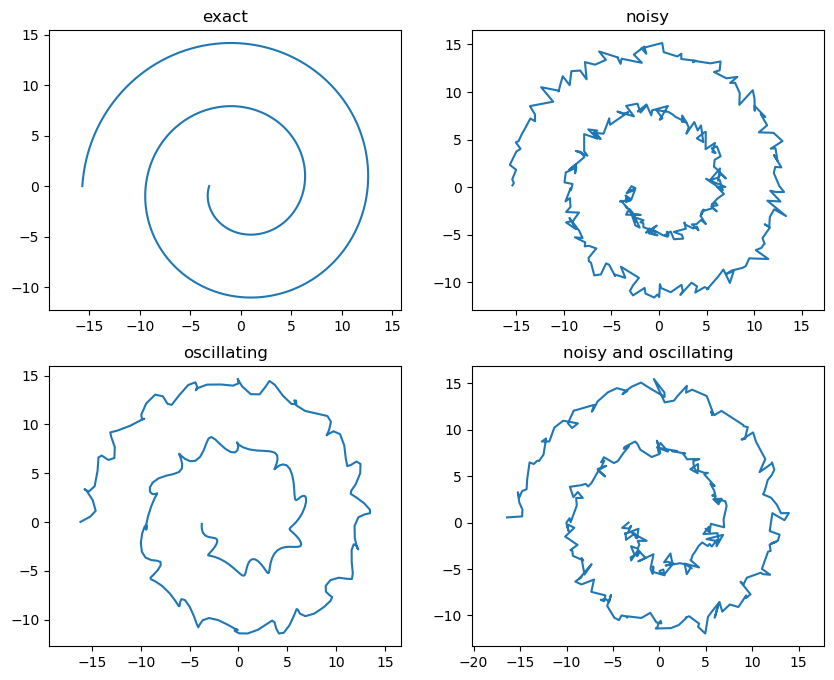

In [21]:
fig=plt.figure(figsize=(10,8))

for i,(name,values) in enumerate(spirals2.items()):
    plt.subplot(2,2,1+i); plt.axis('equal')
    plt.title(name)
    plt.plot(*values)

In [22]:
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'cost':1,
    'verbosity':0,
    'stopAtDistance':3,
})
sides = np.array([np.min(spiral2_exact,axis=1)-5,np.max(spiral2_exact,axis=1)+5]).T
hfmIn.SetRect(sides=sides,dimx=400)
X=hfmIn.Grid()

In [23]:
tubes = {}
for name,curve in spirals2.items():
    hfmIn['seeds'] = curve.T
    hfmOut = hfmIn.Run()
    tubes[name] = hfmOut['values']

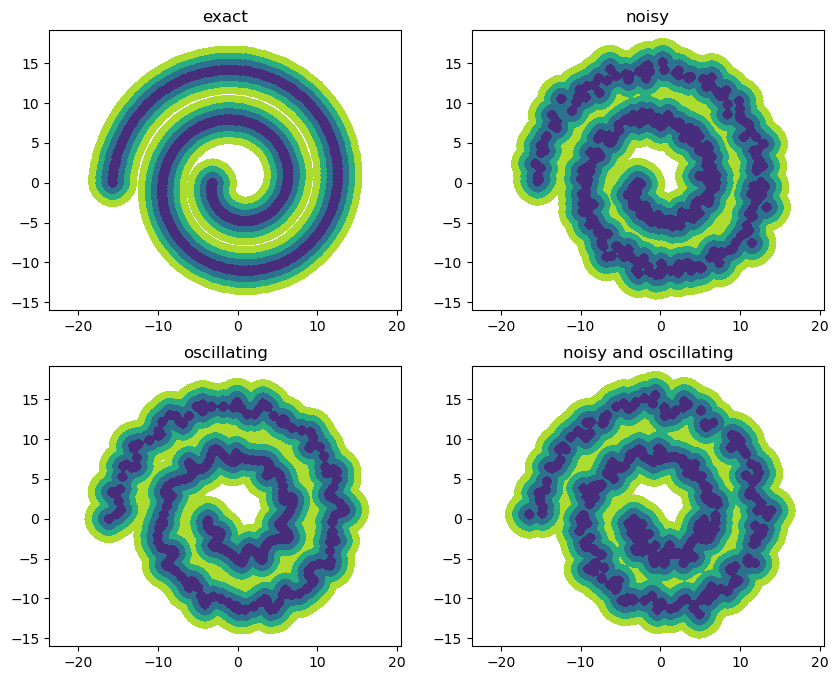

In [24]:
plt.figure(figsize=[10,8])
for i,(name,values) in enumerate(tubes.items()):
    plt.subplot(2,2,i+1); plt.axis('equal')
    plt.title(name)
    plt.contourf(*X,values,levels=np.linspace(0,3,5))

### 2.2 Curve smoothing

The algorithm below implements the full curve smoothing procedure, which can be described in more detail as follows:
* Computation of the distance to the original curve, until some distance $r>0$, using isotropic fast marching.
* Construction of the set $\Gamma$, which mainly consists of the boundary of the $r$ neighborhood to the curve. We also introduce in $\Gamma$ the points where the fronts originating from different parts of the curve meet. Without this enhancement, one must carefully choose a $r$ to avoid shortcuts.
* Computation of the medial axis $M$ of $\Gamma$, using again isotropic fast marching.
* Construction of a Riemannian metric, favoring paths which stay close and tangent to $M$. For that purpose we rely on the eigen-analysis of the hessian of $d_\Gamma$.
* Computation of a path joining the two extremities of the original curve, with minimal length w.r.t. the constructed Riemannian metric, using anisotropic fast marching.

The algorithm is fairly robust to parameter changes. In particular, the anisotropic fast marching method in the last step may be replaced with an isotropic method without much change to the results; but since there is a natural anisotropy defined, why not use it ?

In [25]:
def smooth_medial(curve,rmax,dimx,
                  sigma=2.,cmin=0.01,anisotropy=10.,rho=8.,
                  param=None,param_jump=0.1,verbosity=0,order=(2,2,1)):
    """
    Smooth a curve, by extracting the shortest path through the medial axis of its tubular boundary.
    Inputs:
     - curve (float array, shape=(vdim,nPts)) : the curve to be smoothed
     - rmax (float): diameter of the tubular neighborhood
     - dimx (int): number of discretization points along the horizontal axis
     - sigma (float, optional): radius of the gaussian kernel, measured in pixels
     - cmin (float, optional): lower bound on the cost of travel
     - rho (float, optional): introduces an additional factor exp( -d_Gamma/(rho*dx) ) in the cost,
       where dx is the grid scale. Mostly useful in three dimensions.
     - anisotropy (float, optional): upper bound on the anisotropy
     - param (float array, shape=(nPts,), optional): a parametrization of the curve to be smoothed
     - param_jump (float, optional): two points of the curve whose parameter difference exceeds 
       this threshold are considered irrelevant to each other
     - order (tuple(int,int,int), optional): the order of the fast marching methods to be used
    """
    # Compute the distance to the curve
    if param is None: param = np.linspace(0,1,curve.shape[1])
    vdim=len(curve)
    hfmIn1 = Eikonal.dictIn({
        'model':f"Isotropic{vdim}",
        'verbosity':verbosity,
        'exportValues':1,
        'cost':1,
        'seeds':curve.T,
        'seedValueVariation':param.reshape(1,-1),
        'order':order[0],
    })
    sides = np.array([np.min(curve,axis=1)-rmax,np.max(curve,axis=1)+rmax]).T
    hfmIn1.SetRect(sides=sides,dimx=dimx)
    X = hfmIn1.Grid()
    dx = hfmIn1['gridScale']
    hfmIn1['stopAtDistance']=rmax+2*dx
    hfmOut1 = hfmIn1.Run()
    values1 = hfmOut1['values'].value # Discard AD information
    values1[values1>rmax]=np.inf
    param1 = hfmOut1['values'].gradient(0) # Propagates the parametrization to the domain
    
    # Detect the tubular neighborhood boundary
    values1_max = maximum_filter(values1,size=3,mode='constant',cval=np.inf)
    param1_max = maximum_filter(param1,size=3)
    param1_min = minimum_filter(param1,size=3)
    bd = np.logical_and(np.isfinite(values1),
                        np.logical_or(np.isinf(values1_max),param1_max>=param_jump+param1_min))
    
    # Compute the distance to the tubular neighborhood boundary    
    seeds2 = X[:,bd].T
    seedValues2 = -values1[bd]
    hfmIn2 = Eikonal.dictIn({
        'model':f"Isotropic{vdim}",
        'verbosity':verbosity,
        'exportValues':1,
        'cost':1,
        'walls':np.isinf(values1),
        'seeds':seeds2,
        'seedValues':seedValues2,
        'order':order[1],
    })
    hfmIn2.SetRect(sides=sides,dimx=dimx)
    hfmOut2 = hfmIn2.Run()
    values2 = hfmOut2['values']
    
    # Produce a metric that favors the tubular neighborhood centerline    
    values2[np.isinf(values2)]=np.nan
    hess = hessian(values2,sigma)
    walls = np.logical_or(np.isnan(hess.sum(axis=(0,1))),bd)
    hess[:,:,walls]=0. # No incidence, avoids NaNs
    
    def eigen_map(ev):
        """Function used to map the eigenvalues of the hessian into a suitable Riemannian metric"""
        mu = -1.2*sigma*ev/hfmIn2['gridScale'] # Normalization of eigenvalues, expected to lie in [0,1]
        mu = np.maximum(0.,np.minimum(1.,mu)) # Enforce that lies in [0,1]
        mum = mu.max(axis=0)
        cost = 1./(1.+(mum-mu)/cmin) # Minimal cost cmin along the medial axis, maximal cost 1 elsewhere
        cost = np.minimum(cost,anisotropy*np.min(cost,axis=0)) # Bound anisotropy
        if rho: cost *= np.exp(-values2/(rho*dx))
        cost[:,walls]=1. # No incidence, avoids NaNs
        return cost**2 # Riemannian metric eigenvalues equal the squared cost

    time_start=time.time()
    metric = Metrics.Riemann.from_mapped_eigenvalues(hess, eigen_map)
    if verbosity>=1: print(f"metric construction took {time.time()-time_start} seconds")
    
    # Find a shortest path for the metric
    hfmIn3 = Eikonal.dictIn({
        'model':f"Riemann{vdim}",
        'verbosity':verbosity,
        'exportValues':1,
        'metric':metric,
        'walls':walls,
        'seeds':[curve[:,0]],
        'tips':[curve[:,-1]],
        'order':order[2],
    })
    
    hfmIn3.SetRect(sides=sides,dimx=dimx)
    hfmOut3 = hfmIn3.Run()
    hfmOut3['hess']=hess
    
    return hfmOut3['geodesics'][0],((hfmIn1,hfmOut1),(hfmIn2,hfmOut2),(hfmIn3,hfmOut3))

In [26]:
%%time
results2_exact = smooth_medial(spiral2_exact,rmax=3,dimx=400,verbosity=1)

Field seedRadius defaults to 0
Fast marching solver completed in 0.023789 s.
Field seedRadius defaults to 0
Fast marching solver completed in 0.023754 s.
metric construction took 0.0515291690826416 seconds


Field seedRadius defaults to 0
Fast marching solver completed in 0.027858 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
CPU times: user 64.9 ms, sys: 22.5 ms, total: 87.4 ms
Wall time: 281 ms


In [27]:
results2_noisy = smooth_medial(spiral2_noisy,rmax=3,dimx=400)
results2_osc = smooth_medial(spiral2_osc,rmax=3,dimx=400)

In [28]:
results2 = {'exact':results2_exact, 'noisy':results2_noisy, 'oscillating':results2_osc}

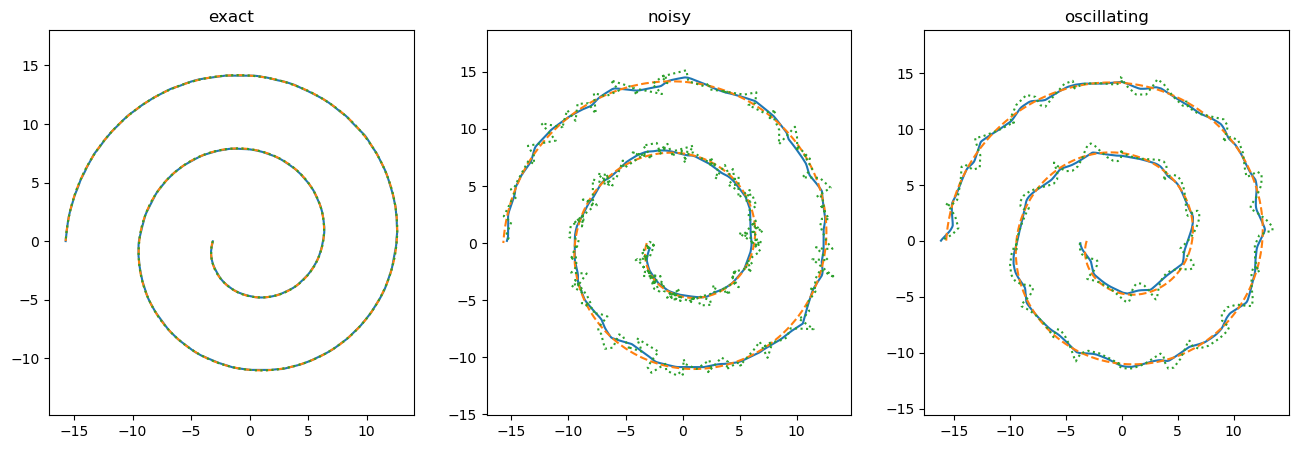

In [29]:
plt.figure(figsize=[16,5])
for i,name in enumerate(results2):
    plt.subplot(1,3,i+1); plt.axis('equal')
    plt.title(name)
    plt.plot(*results2[name][0],label='geodesic')
    plt.plot(*spirals2['exact'],label="exact",linestyle="--")
    plt.plot(*spirals2[name],label="original",linestyle=":")

### 2.3 Analysis of the results

In [30]:
def show_medial(results):
    geo,((hfmIn1,hfmOut1),(hfmIn2,hfmOut2),(hfmIn3,hfmOut3)) = results
    plt.figure(figsize=[16,10])
    X = hfmIn1.Grid()
    
    plt.subplot(2,3,1); plt.axis('equal')
    plt.title("Distance to the input curve")
    plt.contourf(*X,hfmOut1['values'].value)
    
    plt.subplot(2,3,2)
    plt.title("Distance to the tube boundary")
    plt.contourf(*X,hfmOut2['values'])
    
    plt.subplot(2,3,3)
    plt.title("Distance from the seed")
    plt.contourf(*X,hfmOut3['values'])
    
    plt.subplot(2,3,4)
    plt.title("Extension of the curve parametrization")
    plt.contourf(*X,hfmOut1['values'].gradient(0))
    
    plt.subplot(2,3,5)
    plt.title("Maximal speed at a point")
    cost,_ = eigh(hfmIn3['metric'].m)
    plt.contourf(*X,1/cost[0]) # 1/cost[1] for minimal speed
        
    plt.subplot(2,3,6)
    plt.title("Denoised curve")
    plt.plot(*geo,color="black",label='geodesic')

The main property of the theoretical method is reproduced by the implementation: the smooth curve is reproduce (almost) exactly, without any drift introduced by the smoothing procedure.

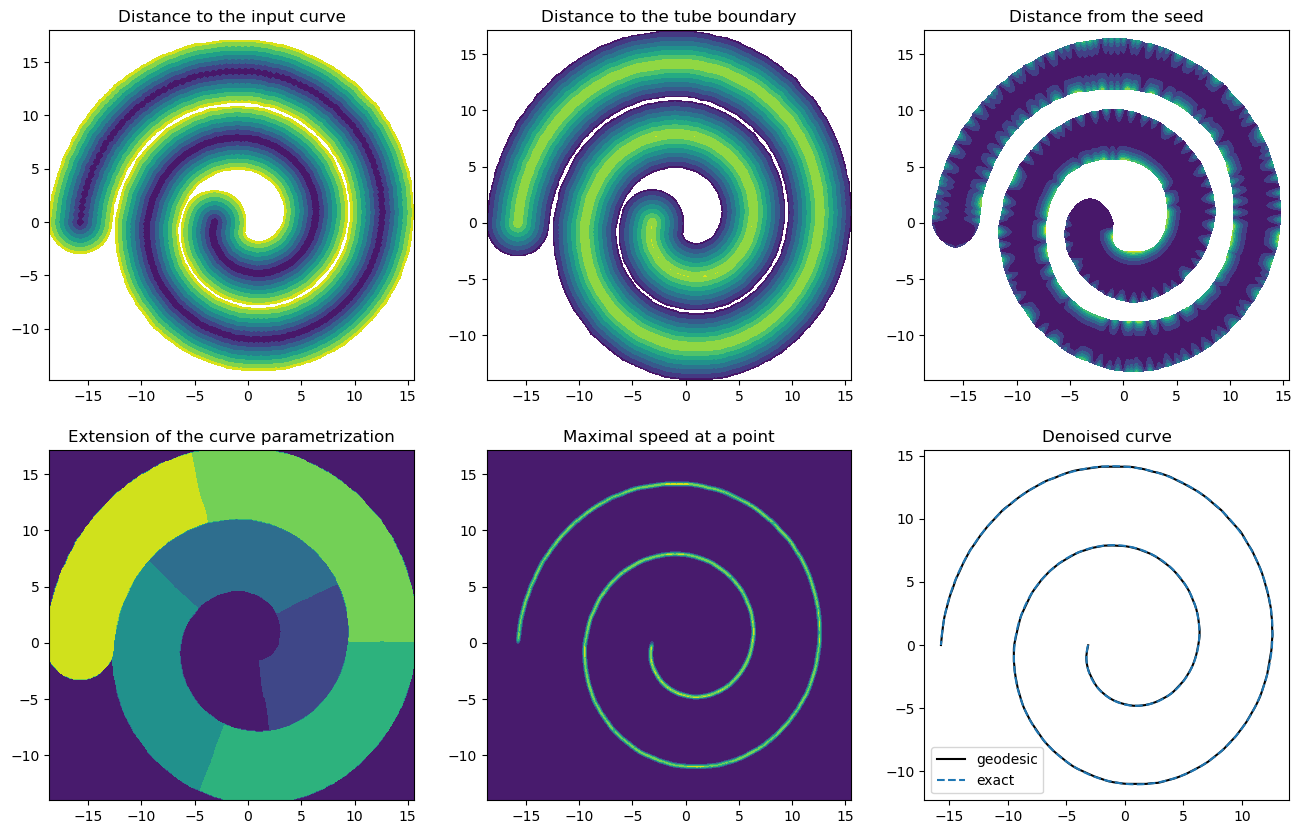

In [31]:
show_medial(results2['exact'])
plt.plot(*spiral2_exact,label="exact",linestyle="--"); plt.legend();

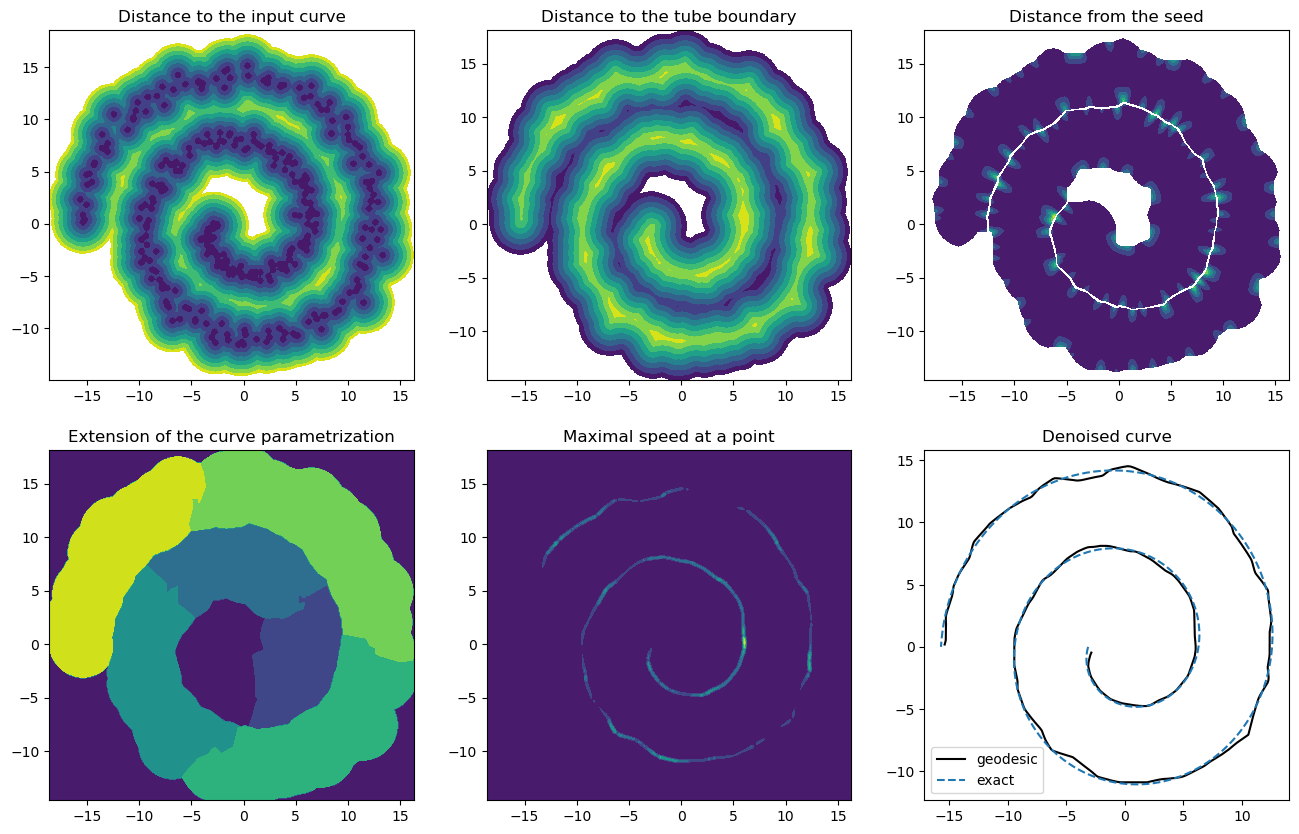

In [32]:
show_medial(results2['noisy'])
plt.plot(*spiral2_exact,label="exact",linestyle="--"); plt.legend();

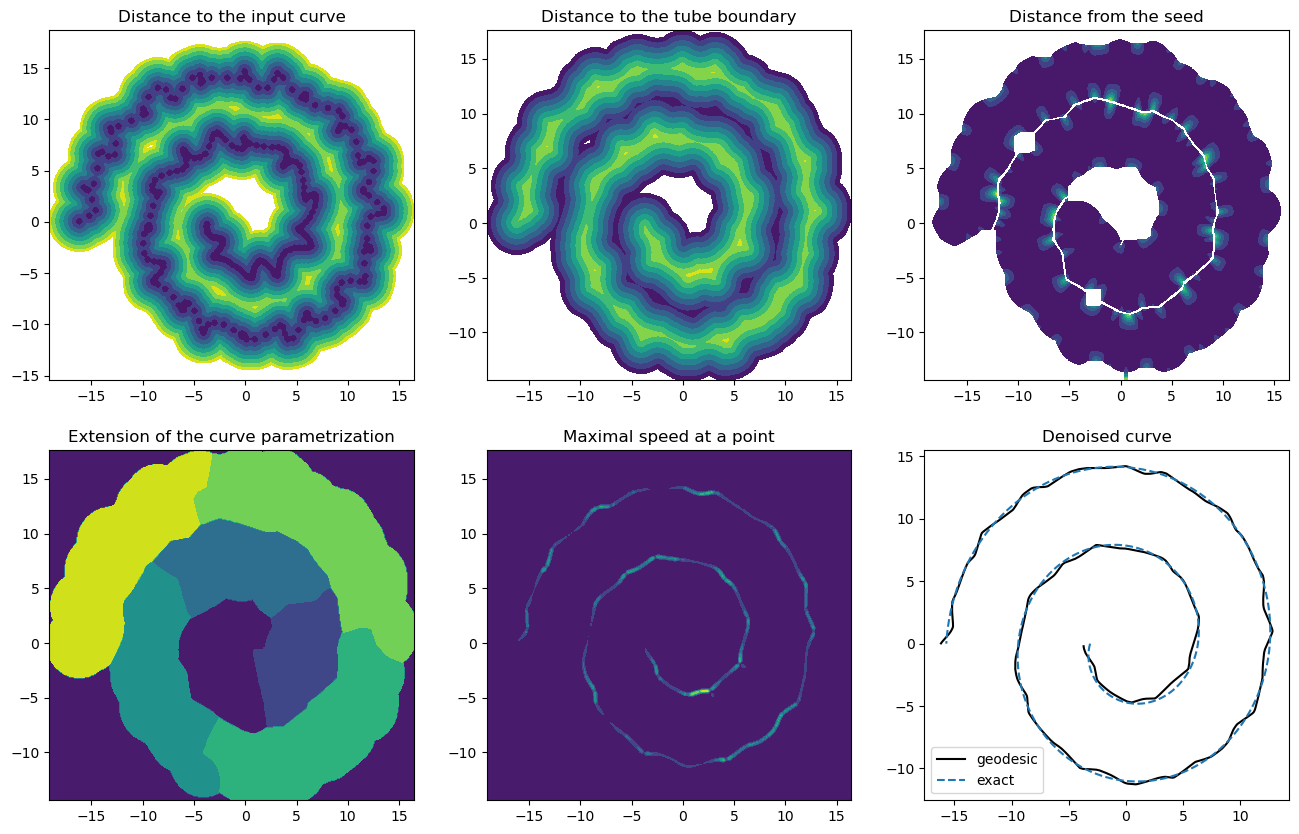

In [33]:
show_medial(results2['oscillating'])
plt.plot(*spiral2_exact,label="exact",linestyle="--"); plt.legend();

### 2.4 Further smoothing ?

Applying a second time, or more, our curve smoothing procedure has almost no effect.
Indeed, the medial axis smoothing procedure does not affect curves whose curvature is below a certain bound. We view this property as a feature, rather than a bug, but it must be taken into account.

In [34]:
curves = [spiral2_osc]
for i in range(3):
    curves.append(smooth_medial(curves[-1],rmax=3,dimx=400)[0])

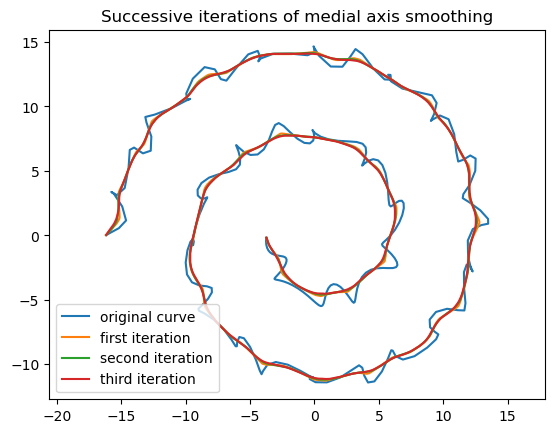

In [35]:
plt.title("Successive iterations of medial axis smoothing")
plt.axis('equal')
plt.plot(*curves[0],label='original curve')
plt.plot(*curves[1],label='first iteration')
plt.plot(*curves[2],label='second iteration')
plt.plot(*curves[3],label='third iteration')
plt.legend();

Further smoothing can be obtained by using applying for instance a mean curvature flow, or some other curve evolution PDE involving e.g. higher order derivatives. We do not explore these techniques here.

## 3. Three dimensional curves

The `smooth_medial` algorithm implemented in the previous section is by construction dimension independent.
We apply it here in three dimension. 

(Curiously, the dominant factor in terms of CPU time is the construction of the metric, which involves computing the eigenvalues and eigenvectors of a large family of $3\times 3$ symmetric matrices. The total execution time of the fast marching amounts to less than half of this time.)

**Specificity in three dimensions.**
The medial axis of a three dimensional object is, typically, a two dimensional piecewise smooth manifold.
A special case arises for the tubular neighborhood, of radius $r$, of a smooth curve, of curvature radius (and local feature size) less than $r$. In that case, the medial axis coincides with the original curve, and is thus a one dimensional object.

However, that property does not extend to the tubular neighborhood of a curve perturbed with some noise or rapid oscillations. In these cases, the medial axis is two dimensional, and our curve smoothing procedure needs needs to select a path through it based on an adequate criterion. We choose to introduce the weight $\exp(-d_\Gamma)$ in the metric, used in the final extraction of the smoothed path, so as to better guide it in the centerline of the tubular structure.

### 3.1 Curve smoothing

In [36]:
def spiral3(t):
    return np.array((np.cos(t),np.sin(t),t/3))
def oscillations3(t):
    t=15*t
    return np.array( (np.cos(.6*t)+np.sin(.4*t),np.cos(.5*t)+np.sin(.7*t),np.cos(0.8*t)+np.sin(0.5*t)) )

In [37]:
spiral3_t = np.linspace(np.pi,5*np.pi,300)
spiral3_exact = spiral3(spiral3_t)
spiral3_noisy = spiral3_exact + 0.2*np.random.normal(size=spiral3_exact.shape)
spiral3_osc = spiral3_exact + 0.2*oscillations3(spiral3_t)
spiral3_noisy_osc = spiral3_exact+ 0.15*(oscillations3(spiral3_t)+np.random.normal(size=spiral3_exact.shape))

spirals3 = {'exact':spiral3_exact,'noisy':spiral3_noisy,
           'oscillating':spiral3_osc,'noisy and oscillating':spiral3_noisy_osc}

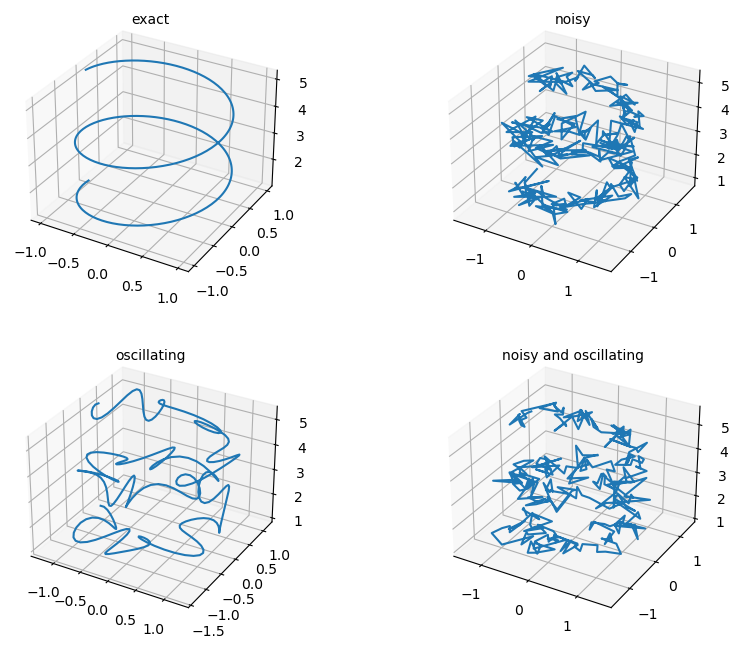

In [38]:
fig=plt.figure(figsize=(10,8))
for i,(name,values) in enumerate(spirals3.items()):
    ax = fig.add_subplot(2,2,1+i,projection='3d')
    Plotting.SetTitle3D(ax,name)
    ax.plot(*values)

In [39]:
%%time
results3_exact = smooth_medial(spiral3_exact,rmax=1,dimx=100,verbosity=1,rho=None)

Field seedRadius defaults to 0
Fast marching solver completed in 0.405004 s.


Field seedRadius defaults to 0
Fast marching solver completed in 0.346985 s.


metric construction took 3.9658780097961426 seconds


Field seedRadius defaults to 0
Fast marching solver completed in 0.230317 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
CPU times: user 2.46 s, sys: 3.3 s, total: 5.75 s
Wall time: 7.61 s


In [40]:
results3_noisy = smooth_medial(spiral3_noisy,rmax=1,dimx=100)

In [41]:
results3_osc = smooth_medial(spiral3_osc,rmax=1,dimx=100,rho=5)

In [42]:
results3 = {'exact':results3_exact, 'noisy':results3_noisy, 'oscillating':results3_osc}

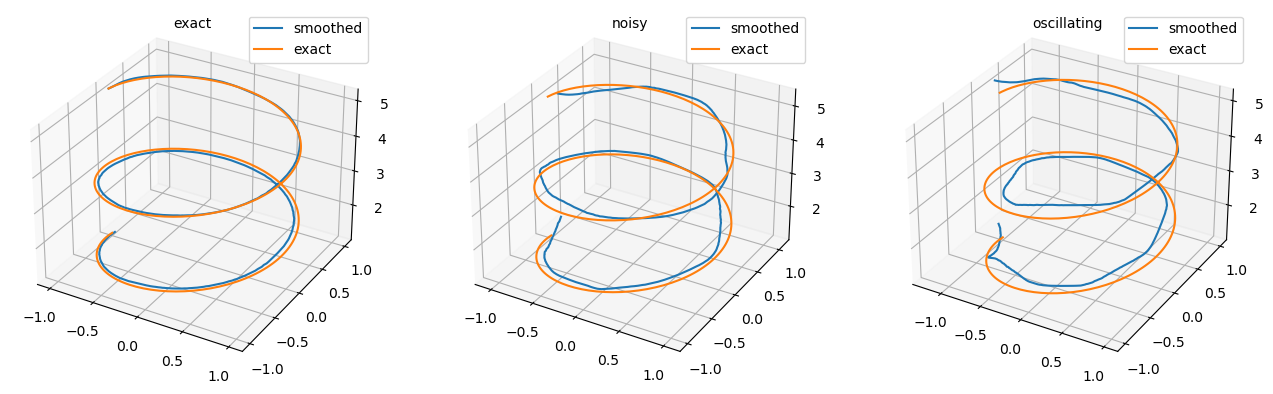

In [43]:
plt.figure(figsize=[16,5])
for i,name in enumerate(['exact','noisy','oscillating']):
    ax=plt.subplot(1,3,1+i,projection='3d')
    geo,_ = results3[name]
    Plotting.SetTitle3D(ax,name)
    ax.plot(*geo,label='smoothed')
    ax.plot(*spiral3_exact,label='exact')
    plt.legend();

### 3.2 Analysis of the results

The distance hessian most negative eigenvalue, shown in the figures below, is by construction a detector of the medial axis. In these slices, one clearly seeds that the medial axis is a one dimensional object for the smooth curve, and a two dimensional object in the other cases.

In [44]:
def show_medial3(results):
    geo,((hfmIn1,hfmOut1),(hfmIn2,hfmOut2),(hfmIn3,hfmOut3)) = results
    X = hfmIn1.Grid()
    slice0 = X.shape[1]//2
    X0 = X[1:3,slice0] # grid for slice along first axis
    
    print("Showing central slice along the first axis")
    plt.figure(figsize=(16,15))
    
    plt.subplot(3,3,1); plt.axis('equal')
    plt.title("Distance to the input curve")
    plt.contourf(*X0,hfmOut1['values'].value[slice0])
    plt.colorbar()
    
    plt.subplot(3,3,2); plt.axis('equal')
    plt.title("Distance to the tube boundary")
    plt.contourf(*X0,hfmOut2['values'][slice0])
    plt.colorbar()
    
    plt.subplot(3,3,3); plt.axis('equal')
    plt.title("Distance from the seed")
    plt.contourf(*X0,hfmOut3['values'][slice0])
    plt.colorbar()
    
    plt.subplot(3,3,4); plt.axis('equal')
    plt.title("Extension of the curve parametrization")
    plt.contourf(*X0,hfmOut1['values'].gradient(0)[slice0])
    plt.colorbar()
    
    plt.subplot(3,3,5); plt.axis('equal')
    plt.title("Maximal speed at a point")
    cost,_ = eigh(hfmIn3['metric'].m[:,:,slice0])
    speed = 1./np.sqrt(cost)
    plt.contourf(*X0,speed[0]) # 1/cost[1] for minimal speed
    plt.colorbar()
    
#    plt.subplot(3,3,6); plt.axis('equal')    
#    plt.title("Anisotropy")
#    plt.contourf(*X0,speed[0]/speed[2])
#    plt.colorbar()
    
    plt.subplot(3,3,6); plt.axis('equal')   
    plt.title("Distance hessian most negative eigenvalue")
    mu,_ = eigh(hfmOut3['hess'][:,:,slice0])
    plt.contourf(*X0,mu[0])
    plt.colorbar()

#    plt.subplot(3,3,8); plt.axis('equal')   
#    plt.title("Distance hessian middle eigenvalue")
#    mu,_ = eigh(hfmOut3['hess'][:,:,slice0])
#    plt.contourf(*X0,mu[1])
#    plt.colorbar()


Showing central slice along the first axis


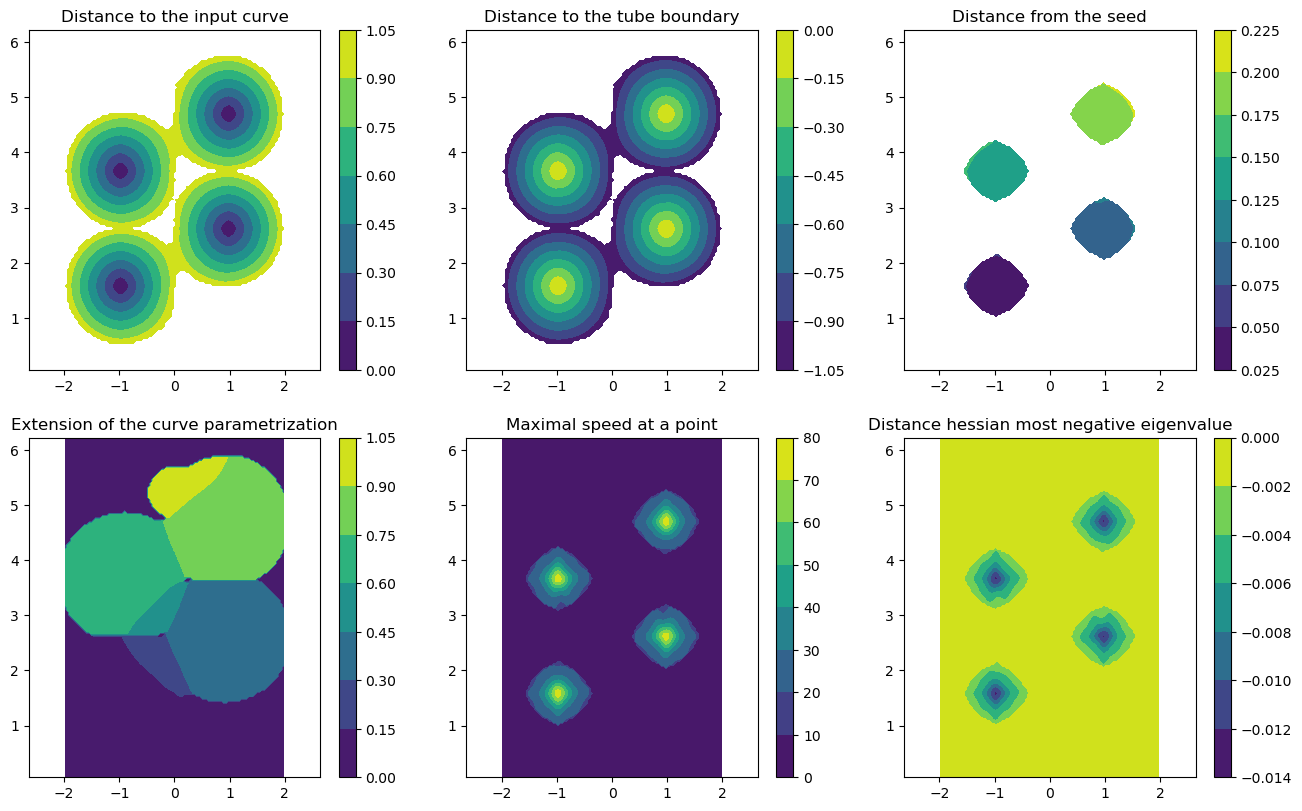

In [45]:
show_medial3(results3['exact'])

Showing central slice along the first axis


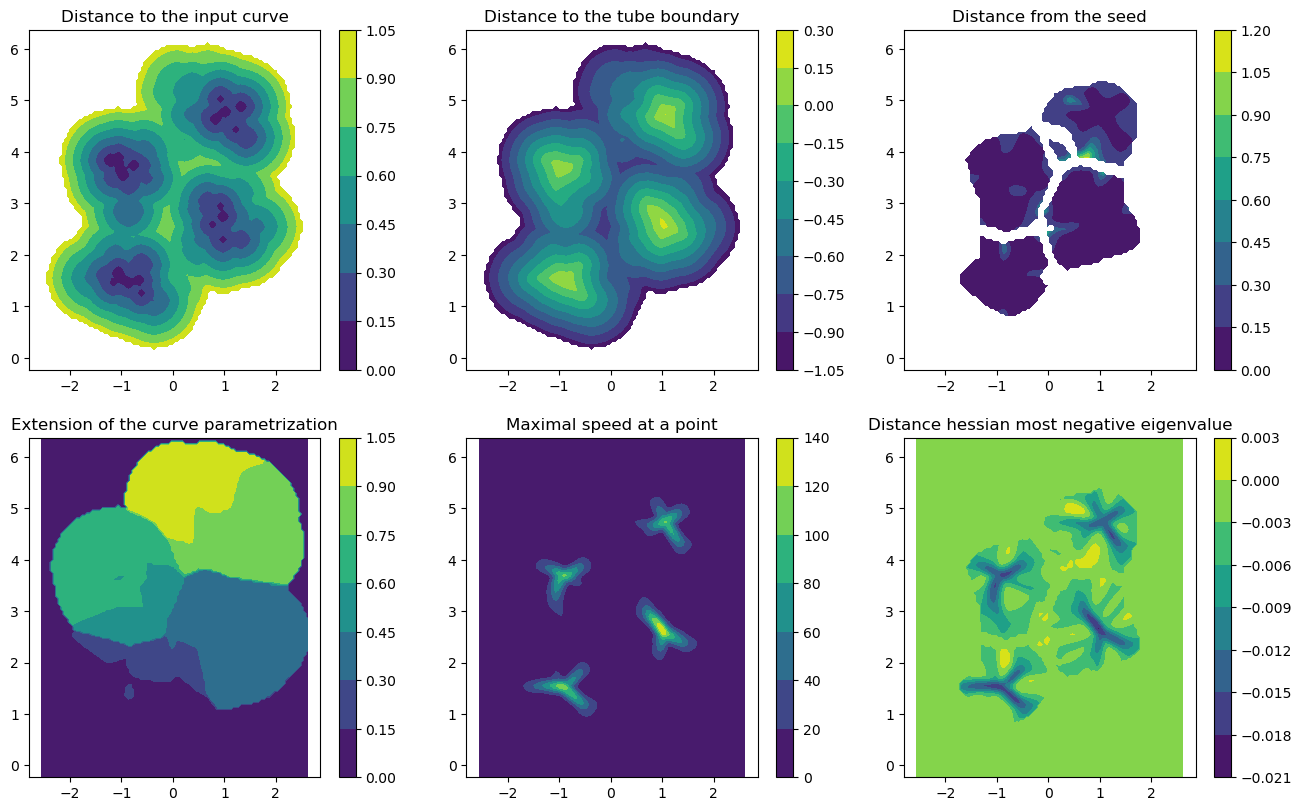

In [46]:
show_medial3(results3['noisy'])

Showing central slice along the first axis


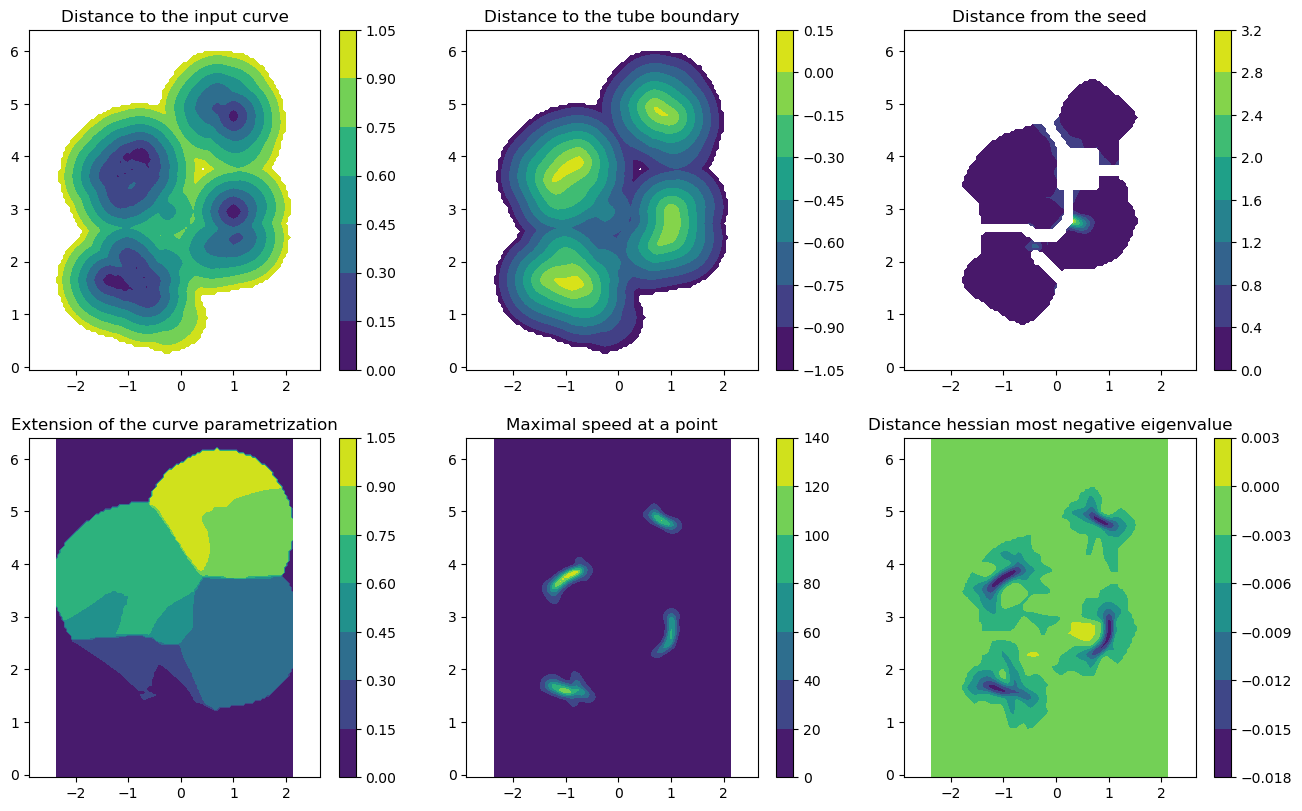

In [47]:
show_medial3(results3['oscillating'])

**Three dimensional plots.** Displaying three dimensional data using matplotlib is quite a bad idea: the execution is extremely slow, and the results are not very readable. Three dimensional plots may be added when I settle a choice of 3D plotting library.


<!---
### 3.2 Three dimensional plots


def show_medial3b(results,display=None):
    geo,((hfmIn1,hfmOut1),(hfmIn2,hfmOut2),(hfmIn3,hfmOut3)) = results
    plt.figure(figsize=[16,10])
    X = hfmIn1.Grid()
    i=1
    
    if display.get('geodesic',None): # Fastest to display
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        ax.plot(*geo,color="black",label='geodesic')
        
    if 'distance to curve' in display:
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        plt.title("Distance to the input curve")
        ax.voxels(hfmOut1['values']<display['distance to curve'])
        
    if 'distance to tube' in display:
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        plt.title("Distance to the tube")
        ax.voxels(hfmOut2['values']<display['distance to tube'])
        
    if 'distance to seed' in display:
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        plt.title("Distance to the seed")
        ax.voxels(hfmOut3['values']<display['distance to seed'])
        
    if 'parametrization' in display:
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        plt.title("Parametrization")
        ax.voxels(hfmOut1['valueVariation'].squeeze(axis=-1)<display['parametrization'])
    
    if 'speed' in display:
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        plt.title("Speed")
        speeds = 1./np.sqrt(hfmIn3['metric'].eigvals())
        ax.voxels(speeds[0]>display['speed'])
    
    if 'anisotropy' in display:
        ax = plt.subplot(2,3,i,projection='3d'); i+=1
        plt.title("Anisotropy")
        ax.voxels(hfmIn3['metric'].anisotropy()>display['anisotropy'])
        
#show_medial3b(results3['exact'],{'anisotropy':10,'speed':5})

--->